# Домашнее задание № 8

## Задание 1 (4 балла) 

Обучите 8 моделей для задачи классификации текста (датасет - lenta_40k ). А именно:  
1) модель с 1 GRU слоем;   
2) модель с 1 LSTM слоем    
3) модель с 1 GRU и 1 LSTM слоем  
4) модель с 1 BIGRU и 2 LSTM слоями  
5) модель с 5 GRU слоями и 3 LSTM слоями  
6) модель 1 BIGRU и 1 BILSTM слоями, причем так чтобы модели для forward и backward прохода отличались   
7) модель, где последовательно идут слои: LSTM, GRU, BILSTM, BIGRU, GRU, LSTM  
8) модель с 50 любыми рекуррентными слоями  


Параметр units и размер эмбединга можете задать любой. Оцените качество каждой модели и определите победителя.

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="13,14,6,7"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"

import pandas as pd
import numpy as np
import json
import re
from path import glob
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import train_test_split
from razdel import tokenize as razdel_tokenize
from string import punctuation
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
from tqdm.notebook import tqdm
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, classification_report
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt

%matplotlib inline

punctuation += '«—‐»'

In [2]:
def tokenize_text(text):
    text = re.sub(r'[\)\(»«:.,/;•!Ð£©Ñ‡²µÑ¶"=%\\^…“”]+', '', text)
    text = re.sub(r'[_—–-]+', ' ', text)
    tokenized_text = [word.text.strip(punctuation) for word in razdel_tokenize(text)]
    tokenized_text = [word.lower() for word in tokenized_text if word and word not in punctuation]
    return tokenized_text

In [3]:
data = pd.read_csv('lenta_40k.csv')

In [4]:
data

,text,topic
0,Россия должна сотрудничать с Всемирным антидоп...,Спорт
1,Уголовный суд Кувейта 28 июня освободил под за...,Мир
2,Французский журнал Charlie Hebdo опубликовал н...,Интернет и СМИ
3,В Петербурге в доме № 53 по улице Лени Голиков...,Россия
4,"В московском аэропорту ""Домодедово"" задержан г...",Россия
...,...,...
44351,Российский Минфин может пересмотреть минимальн...,Экономика
44352,Сотрудники Службы безопасности Украины (СБУ) с...,Бывший СССР
44353,Америке следует задуматься над поставками на У...,Силовые структуры
44354,"Опознаны тела 71 человека, погибшего в результ...",Мир


In [5]:
data['topic'].value_counts()

Россия               9622
Мир                  8193
Экономика            4768
Спорт                3894
Наука и техника      3204
Культура             3183
Бывший СССР          3182
Интернет и СМИ       2643
Из жизни             1679
Дом                  1315
Силовые структуры    1203
Ценности              460
Бизнес                433
Путешествия           418
69-я параллель         82
Крым                   43
Культпросвет           25
Легпром                 6
Библиотека              3
Name: topic, dtype: int64

In [6]:
data['tokens_text'] = data['text'].apply(lambda x: tokenize_text(x))

In [7]:
from collections import Counter

vocab = Counter()

for tokens in data['tokens_text']:
    vocab.update(tokens)

In [8]:
filtered_vocab = {}

for word, freq in vocab.items():
    if freq > 10:
        filtered_vocab[word] = freq

In [9]:
len(vocab), len(filtered_vocab)

(300578, 50968)

In [10]:
# индексируем слова
word2id = {'PAD': 0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [11]:
train, test = train_test_split(data, test_size=0.1, random_state=42, shuffle=True)
test, val = train_test_split(test, test_size=0.5, random_state=42, shuffle=True)

In [12]:
train.shape, test.shape, val.shape

((39920, 3), (2218, 3), (2218, 3))

In [13]:
train_tokenized_texts = train['tokens_text'].values
val_tokenized_texts = val['tokens_text'].values
test_tokenized_texts = test['tokens_text'].values

In [14]:
le = LabelEncoder()
train_labels = le.fit_transform(train['topic'])
val_labels = le.transform(val['topic'])
test_labels = le.transform(test['topic'])

In [15]:
train['text'].apply(lambda x: len(x.split())).mean()

179.73364228456913

In [16]:
max_length = 180

train_ids = [torch.LongTensor([word2id[token] for token in row if token in word2id][:max_length]) for row in train_tokenized_texts]
test_ids = [torch.LongTensor([word2id[token] for token in row if token in word2id][:max_length]) for row in test_tokenized_texts]
val_ids = [torch.LongTensor([word2id[token] for token in row if token in word2id][:max_length]) for row in val_tokenized_texts]

In [17]:
pad_train_ids = pad_sequences(train_ids, maxlen=max_length, padding='post', truncating='post')
pad_test_ids = pad_sequences(test_ids, maxlen=max_length, padding='post', truncating='post')
pad_val_ids = pad_sequences(val_ids, maxlen=max_length, padding='post', truncating='post')

In [18]:
pad_train_ids = torch.tensor(pad_train_ids)
pad_test_ids = torch.tensor(pad_test_ids)
pad_val_ids = torch.tensor(pad_val_ids)

train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)
test_labels = torch.tensor(test_labels)

In [19]:
train_dataset = torch.utils.data.TensorDataset(pad_train_ids, train_labels)
val_dataset = torch.utils.data.TensorDataset(pad_val_ids, val_labels)
test_dataset = torch.utils.data.TensorDataset(pad_test_ids, test_labels)

In [20]:
batch_size = 200

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, sampler=torch.utils.data.RandomSampler(train_dataset))
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, sampler=torch.utils.data.SequentialSampler(val_dataset))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size, sampler=torch.utils.data.SequentialSampler(test_dataset))

In [21]:
vocab_size = len(filtered_vocab)
emb_dim = 256
hidden_size = 512
n_target = data['topic'].nunique()
n_epochs = 3

In [22]:
def train_model(model, n_epochs, train_dataloader, validation_dataloader, lr):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, threshold=0.01)
    loss = torch.nn.NLLLoss()
    loss_set = []
    val_loss_set = []
    

    for epoch in range(n_epochs):
        epoch_loss_set = []
        model.train()

        for j, batch in enumerate(tqdm(train_dataloader)):
              
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_labels = batch
              
            optimizer.zero_grad()
            pred_probs = model.forward(b_input_ids)

            my_loss = loss(pred_probs, b_labels)
            epoch_loss_set.append(my_loss.item())
            my_loss.backward()
                  
            pred_probs = pred_probs.detach().to('cpu').numpy()
            pred_labels = pred_probs.argmax(axis=1)
            b_labels = b_labels.to('cpu').numpy()
            
            optimizer.step()
              
            if j == 0:
                all_train_labels = b_labels
                all_train_preds = pred_labels
            else:
                all_train_labels = np.hstack([all_train_labels, b_labels])
                all_train_preds = np.hstack([all_train_preds, pred_labels])
                
            #scheduler.step(np.mean(epoch_loss_set))  
        
        loss_set.extend(epoch_loss_set)
          
        train_f1 = f1_score(all_train_labels, all_train_preds, average="weighted")
#           print(classification_report(all_train_labels, all_train_preds))  
        print()
        print('Epoch {} ... Train f1: {:.2f} ... Mean train loss: {:.4f}'.format(epoch, train_f1, np.mean(epoch_loss_set)))
        print()

        epoch_val_loss_set = []

        model.eval()

        for j, batch in enumerate(tqdm(validation_dataloader)):
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_labels = batch
              
  #             val_labels = np.zeros([b_labels.shape[0], n_target])
  #             val_preds = np.zeros([b_labels.shape[0], n_target])
              
            with torch.no_grad():
                pred_probs = model.forward(b_input_ids)
                val_loss = loss(pred_probs, b_labels)
                epoch_val_loss_set.append(val_loss.item())

                b_labels = b_labels.to('cpu').numpy()
                pred_probs = pred_probs.detach().to('cpu').numpy()
                pred_labels = pred_probs.argmax(axis=1)
              
            if j == 0:
                all_val_labels = b_labels
                all_val_preds = pred_labels
            else:
                all_val_labels = np.hstack([all_val_labels, b_labels])
                all_val_preds = np.hstack([all_val_preds, pred_labels])
          
        #scheduler.step(np.mean(epoch_val_loss_set))
          
        val_loss_set.extend(epoch_val_loss_set)

        val_f1 = f1_score(all_val_labels, all_val_preds, average="weighted")
#           print(classification_report(all_val_labels, all_val_preds))  
        print()
        print('Epoch {} ... Val f1: {:.2f} ... Mean val loss: {:.4f}'.format(epoch, val_f1, np.mean(epoch_val_loss_set)))
        print()
        print('-------------------------------------------------------------------------------------------------------------------------')
        print()
        
    test_labels, test_pred_labels, test_loss_set = predict_test_labels(model, test_dataloader)
    test_f1 = f1_score(test_labels, test_pred_labels, average="weighted")
    print('Final epoch ... test f1: {:.2f} ... Mean test loss: {:.4f}'.format(test_f1, np.mean(test_loss_set)))
    
    return model, loss_set, val_loss_set

def predict_test_labels(model, test_dataloader):
    loss = torch.nn.NLLLoss()
    test_preds = []
    test_labels = []
    test_loss_set = []
    for batch in tqdm(test_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_labels = batch
        with torch.no_grad():
            pred_probs = model.forward(b_input_ids)
            pred_labels = pred_probs.detach().to('cpu').numpy()
            pred_labels = pred_labels.argmax(axis=1)
            test_loss = loss(pred_probs, b_labels)
            test_loss_set.append(test_loss.item())
            test_preds.extend(pred_labels)
            test_labels.extend(b_labels.to('cpu').numpy())
    return np.array(test_labels), np.array(test_preds), test_loss_set

def plot_losses(train_loss, val_loss):
    plt.figure(figsize=(20,5))

    fig = plt.figure(1)
    axis = fig.add_subplot(1,2,1)
    axis.plot(train_loss)
    plt.title('Train Loss')

    fig = plt.figure(1)
    axis = fig.add_subplot(1,2,2)
    axis.plot(val_loss)
    plt.title('Val Loss')

    plt.show()

In [23]:
device = torch.device('cpu' if not torch.cuda.is_available() else 'cuda')
device

device(type='cuda')

  0%|          | 0/799 [00:00<?, ?it/s]


Epoch 0 ... Train f1: 0.49 ... Mean train loss: 1.5197



  0%|          | 0/45 [00:00<?, ?it/s]


Epoch 0 ... Val f1: 0.70 ... Mean val loss: 0.9007

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/799 [00:00<?, ?it/s]


Epoch 1 ... Train f1: 0.79 ... Mean train loss: 0.6366



  0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1 ... Val f1: 0.76 ... Mean val loss: 0.7533

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/45 [00:00<?, ?it/s]

Final epoch ... test f1: 0.76 ... Mean test loss: 0.7209


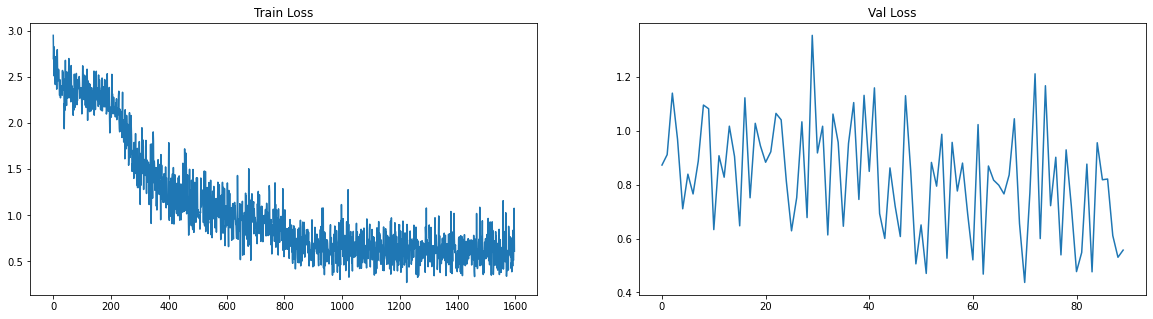

In [121]:
class clf_1(torch.nn.Module):
    def __init__(self, VOCAB_SIZE, EMB_DIM, HID_SIZE, N_TARG):
        super().__init__()
        self.VOCAB_SIZE = VOCAB_SIZE
        self.EMB_DIM = EMB_DIM
        self.HID_SIZE = HID_SIZE
        self.N_TARG = N_TARG
        self.embedding = torch.nn.Embedding(self.VOCAB_SIZE + 1, self.EMB_DIM)
        self.gru = torch.nn.GRU(self.EMB_DIM, self.HID_SIZE, num_layers=1, batch_first=True)
        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(.1),
            torch.nn.Linear(self.HID_SIZE, self.N_TARG),
            torch.nn.LogSoftmax()
        )
        
    def forward(self, input_ids):
        embedding = self.embedding(input_ids)
        output, h = self.gru(embedding)
        scores = self.classifier(h[-1])
        return scores

n_epochs = 2

model = clf_1(vocab_size, emb_dim, hidden_size, n_target)
model.to(device)

model, loss_set, val_loss_set = train_model(model = model, 
                                            n_epochs = n_epochs, 
                                            train_dataloader = train_dataloader, 
                                            validation_dataloader = val_dataloader,
                                            lr = 0.001)

plot_losses(loss_set, val_loss_set)

  0%|          | 0/799 [00:00<?, ?it/s]


Epoch 0 ... Train f1: 0.15 ... Mean train loss: 2.2524



  0%|          | 0/45 [00:00<?, ?it/s]


Epoch 0 ... Val f1: 0.19 ... Mean val loss: 2.0572

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/799 [00:00<?, ?it/s]


Epoch 1 ... Train f1: 0.40 ... Mean train loss: 1.6294



  0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1 ... Val f1: 0.55 ... Mean val loss: 1.2920

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/799 [00:00<?, ?it/s]


Epoch 2 ... Train f1: 0.69 ... Mean train loss: 0.9576



  0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2 ... Val f1: 0.69 ... Mean val loss: 0.9920

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/799 [00:00<?, ?it/s]


Epoch 3 ... Train f1: 0.81 ... Mean train loss: 0.6006



  0%|          | 0/45 [00:00<?, ?it/s]


Epoch 3 ... Val f1: 0.70 ... Mean val loss: 0.9740

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/799 [00:00<?, ?it/s]


Epoch 4 ... Train f1: 0.90 ... Mean train loss: 0.3408



  0%|          | 0/45 [00:00<?, ?it/s]


Epoch 4 ... Val f1: 0.73 ... Mean val loss: 1.0190

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/45 [00:00<?, ?it/s]

Final epoch ... test f1: 0.73 ... Mean test loss: 0.9574


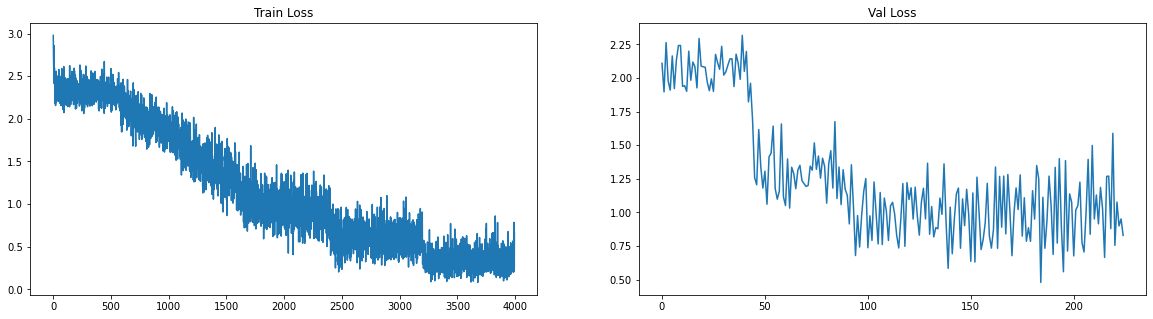

In [122]:
class clf_2(torch.nn.Module):
    def __init__(self, VOCAB_SIZE, EMB_DIM, HID_SIZE, N_TARG):
        super().__init__()
        self.VOCAB_SIZE = VOCAB_SIZE
        self.EMB_DIM = EMB_DIM
        self.HID_SIZE = HID_SIZE
        self.N_TARG = N_TARG
        self.embedding = torch.nn.Embedding(self.VOCAB_SIZE + 1, self.EMB_DIM)
        self.lstm = torch.nn.LSTM(self.EMB_DIM, self.HID_SIZE, num_layers=1, batch_first=True)
        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(.1),
            torch.nn.Linear(self.HID_SIZE, self.N_TARG),
            torch.nn.LogSoftmax()
        )
        
    def forward(self, input_ids):
        embedding = self.embedding(input_ids)
        output, (h, *_) = self.lstm(embedding)
        scores = self.classifier(h[-1])
        return scores

n_epochs = 5

model = clf_2(vocab_size, emb_dim, hidden_size, n_target)
model.to(device)

model, loss_set, val_loss_set = train_model(model = model, 
                                            n_epochs = n_epochs, 
                                            train_dataloader = train_dataloader, 
                                            validation_dataloader = val_dataloader,
                                            lr = 1e-3)

plot_losses(loss_set, val_loss_set)

  0%|          | 0/799 [00:00<?, ?it/s]


Epoch 0 ... Train f1: 0.37 ... Mean train loss: 1.8001



  0%|          | 0/45 [00:00<?, ?it/s]


Epoch 0 ... Val f1: 0.62 ... Mean val loss: 1.1395

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/799 [00:00<?, ?it/s]


Epoch 1 ... Train f1: 0.73 ... Mean train loss: 0.8478



  0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1 ... Val f1: 0.75 ... Mean val loss: 0.8225

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/799 [00:00<?, ?it/s]


Epoch 2 ... Train f1: 0.86 ... Mean train loss: 0.4532



  0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2 ... Val f1: 0.75 ... Mean val loss: 0.8516

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/45 [00:00<?, ?it/s]

Final epoch ... test f1: 0.75 ... Mean test loss: 0.8237


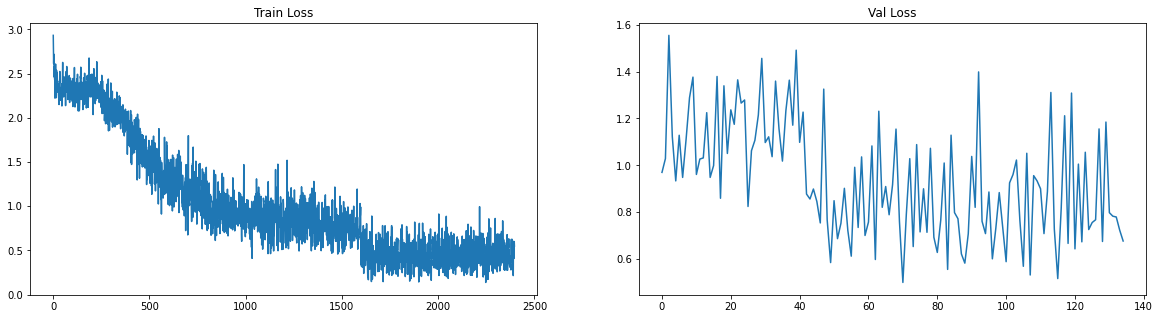

In [94]:
class clf_3(torch.nn.Module):
    def __init__(self, VOCAB_SIZE, EMB_DIM, HID_SIZE, N_TARG):
        super().__init__()
        self.VOCAB_SIZE = VOCAB_SIZE
        self.EMB_DIM = EMB_DIM
        self.HID_SIZE = HID_SIZE
        self.N_TARG = N_TARG
        self.embedding = torch.nn.Embedding(self.VOCAB_SIZE + 1, self.EMB_DIM)
        self.gru = torch.nn.GRU(self.EMB_DIM, self.HID_SIZE, num_layers=1, batch_first=True)
        self.lstm = torch.nn.LSTM(self.HID_SIZE, self.HID_SIZE, num_layers=1, batch_first=True)
        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(.1),
            torch.nn.Linear(self.HID_SIZE, self.N_TARG),
            torch.nn.LogSoftmax()
        )
        
    def forward(self, input_ids):
        embedding = self.embedding(input_ids)
        output, h = self.gru(embedding)
        output, (h, _) = self.lstm(output)
        h = h[-1]
        scores = self.classifier(h)
        return scores
    
n_epochs = 3

model = clf_3(vocab_size, emb_dim, hidden_size, n_target)
model.to(device)

model, loss_set, val_loss_set = train_model(model = model, 
                                            n_epochs = n_epochs, 
                                            train_dataloader = train_dataloader, 
                                            validation_dataloader = val_dataloader,
                                            lr = 0.001)

plot_losses(loss_set, val_loss_set)

  0%|          | 0/799 [00:00<?, ?it/s]


Epoch 0 ... Train f1: 0.18 ... Mean train loss: 2.1913



  0%|          | 0/45 [00:00<?, ?it/s]


Epoch 0 ... Val f1: 0.36 ... Mean val loss: 1.7461

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/799 [00:00<?, ?it/s]


Epoch 1 ... Train f1: 0.55 ... Mean train loss: 1.3034



  0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1 ... Val f1: 0.65 ... Mean val loss: 1.0833

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/799 [00:00<?, ?it/s]


Epoch 2 ... Train f1: 0.74 ... Mean train loss: 0.7976



  0%|          | 0/45 [00:00<?, ?it/s]


Epoch 2 ... Val f1: 0.71 ... Mean val loss: 0.9319

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/799 [00:00<?, ?it/s]


Epoch 3 ... Train f1: 0.86 ... Mean train loss: 0.4664



  0%|          | 0/45 [00:00<?, ?it/s]


Epoch 3 ... Val f1: 0.70 ... Mean val loss: 1.0591

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/799 [00:00<?, ?it/s]


Epoch 4 ... Train f1: 0.92 ... Mean train loss: 0.2549



  0%|          | 0/45 [00:00<?, ?it/s]


Epoch 4 ... Val f1: 0.72 ... Mean val loss: 1.0873

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/45 [00:00<?, ?it/s]

Final epoch ... test f1: 0.73 ... Mean test loss: 1.0779


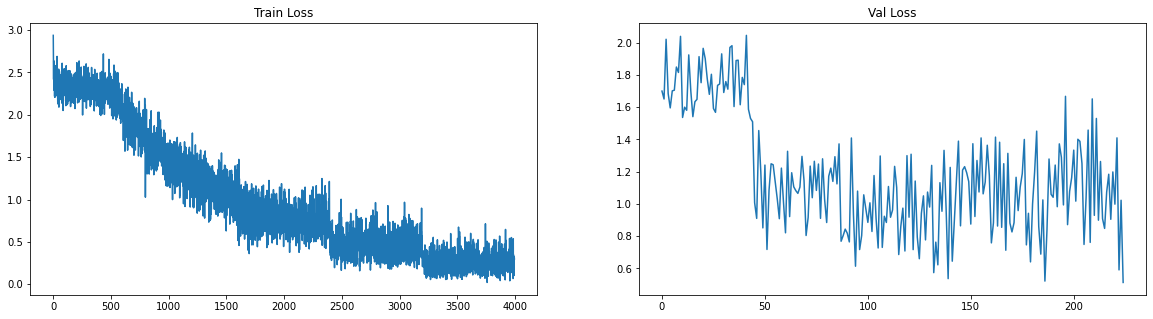

In [96]:
class clf_4(torch.nn.Module):
    def __init__(self, VOCAB_SIZE, EMB_DIM, HID_SIZE, N_TARG):
        super().__init__()
        self.VOCAB_SIZE = VOCAB_SIZE
        self.EMB_DIM = EMB_DIM
        self.HID_SIZE = HID_SIZE
        self.N_TARG = N_TARG
        self.embedding = torch.nn.Embedding(self.VOCAB_SIZE + 1, self.EMB_DIM)
        self.gru = torch.nn.GRU(self.EMB_DIM, self.HID_SIZE, num_layers=1, batch_first=True, bidirectional=True)
        self.lstm = torch.nn.LSTM(2 * self.HID_SIZE, self.HID_SIZE, num_layers=2, batch_first=True)
        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(.1),
            torch.nn.Linear(self.HID_SIZE, self.N_TARG),
            torch.nn.LogSoftmax()
        )
        
    def forward(self, input_ids):
        embedding = self.embedding(input_ids)
        output, h = self.gru(embedding)
        output, (h, _) = self.lstm(output)
        h = h[-1]
        scores = self.classifier(h)
        return scores
    
n_epochs = 5

model = clf_4(vocab_size, emb_dim, hidden_size, n_target)
model.to(device)

model, loss_set, val_loss_set = train_model(model = model, 
                                            n_epochs = n_epochs, 
                                            train_dataloader = train_dataloader, 
                                            validation_dataloader = val_dataloader,
                                            lr = 0.001)

plot_losses(loss_set, val_loss_set)

  0%|          | 0/200 [00:00<?, ?it/s]


Epoch 0 ... Train f1: 0.13 ... Mean train loss: 2.3600



  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 0 ... Val f1: 0.07 ... Mean val loss: 2.3311

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/200 [00:00<?, ?it/s]


Epoch 1 ... Train f1: 0.16 ... Mean train loss: 2.3151



  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 1 ... Val f1: 0.11 ... Mean val loss: 2.2906

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/200 [00:00<?, ?it/s]


Epoch 2 ... Train f1: 0.17 ... Mean train loss: 2.2927



  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 2 ... Val f1: 0.10 ... Mean val loss: 2.2524

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/200 [00:00<?, ?it/s]


Epoch 3 ... Train f1: 0.17 ... Mean train loss: 2.2722



  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 3 ... Val f1: 0.10 ... Mean val loss: 2.2391

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/200 [00:00<?, ?it/s]


Epoch 4 ... Train f1: 0.19 ... Mean train loss: 2.2317



  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 4 ... Val f1: 0.16 ... Mean val loss: 2.1941

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/200 [00:00<?, ?it/s]


Epoch 5 ... Train f1: 0.21 ... Mean train loss: 2.2164



  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 5 ... Val f1: 0.20 ... Mean val loss: 2.1929

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/200 [00:00<?, ?it/s]


Epoch 6 ... Train f1: 0.19 ... Mean train loss: 2.2616



  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 6 ... Val f1: 0.13 ... Mean val loss: 2.3043

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/200 [00:00<?, ?it/s]


Epoch 7 ... Train f1: 0.18 ... Mean train loss: 2.2729



  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 7 ... Val f1: 0.14 ... Mean val loss: 2.2582

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/200 [00:00<?, ?it/s]


Epoch 8 ... Train f1: 0.19 ... Mean train loss: 2.2656



  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 8 ... Val f1: 0.15 ... Mean val loss: 2.2625

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/200 [00:00<?, ?it/s]


Epoch 9 ... Train f1: 0.18 ... Mean train loss: 2.2504



  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 9 ... Val f1: 0.14 ... Mean val loss: 2.2432

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/12 [00:00<?, ?it/s]

Final epoch ... test f1: 0.16 ... Mean test loss: 2.1740


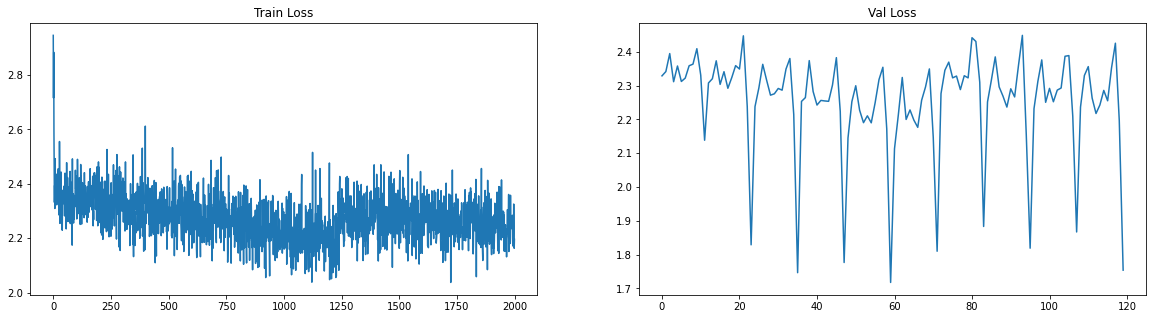

In [128]:
class clf_5(torch.nn.Module):
    def __init__(self, VOCAB_SIZE, EMB_DIM, HID_SIZE, N_TARG):
        super().__init__()
        self.VOCAB_SIZE = VOCAB_SIZE
        self.EMB_DIM = EMB_DIM
        self.HID_SIZE = HID_SIZE
        self.N_TARG = N_TARG
        self.embedding = torch.nn.Embedding(self.VOCAB_SIZE + 1, self.EMB_DIM)
        self.gru = torch.nn.GRU(self.EMB_DIM, self.HID_SIZE, num_layers=5, batch_first=True)
        self.lstm = torch.nn.LSTM(self.HID_SIZE, self.HID_SIZE, num_layers=3, batch_first=True)
        self.dropout = torch.nn.Dropout(.1)
        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(.1),
            torch.nn.Linear(self.HID_SIZE, self.N_TARG),
            torch.nn.LogSoftmax()
        )
        
    def forward(self, input_ids):
        embedding = self.dropout(self.embedding(input_ids))
        output, h = self.gru(embedding)
        output, (h, _) = self.lstm(output)
        h = h.mean(axis=0)
        scores = self.classifier(h)
        return scores
    
vocab_size = len(filtered_vocab)

n_epochs = 10

model = clf_5(vocab_size, emb_dim, hidden_size, n_target)
model.to(device)

model, loss_set, val_loss_set = train_model(model = model, 
                                            n_epochs = n_epochs, 
                                            train_dataloader = train_dataloader, 
                                            validation_dataloader = val_dataloader,
                                            lr = 1e-2)

plot_losses(loss_set, val_loss_set)

  0%|          | 0/799 [00:00<?, ?it/s]


Epoch 0 ... Train f1: 0.54 ... Mean train loss: 1.4217



  0%|          | 0/45 [00:00<?, ?it/s]


Epoch 0 ... Val f1: 0.68 ... Mean val loss: 1.0188

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/799 [00:00<?, ?it/s]


Epoch 1 ... Train f1: 0.76 ... Mean train loss: 0.7481



  0%|          | 0/45 [00:00<?, ?it/s]


Epoch 1 ... Val f1: 0.74 ... Mean val loss: 0.8272

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/45 [00:00<?, ?it/s]

Final epoch ... test f1: 0.74 ... Mean test loss: 0.8510


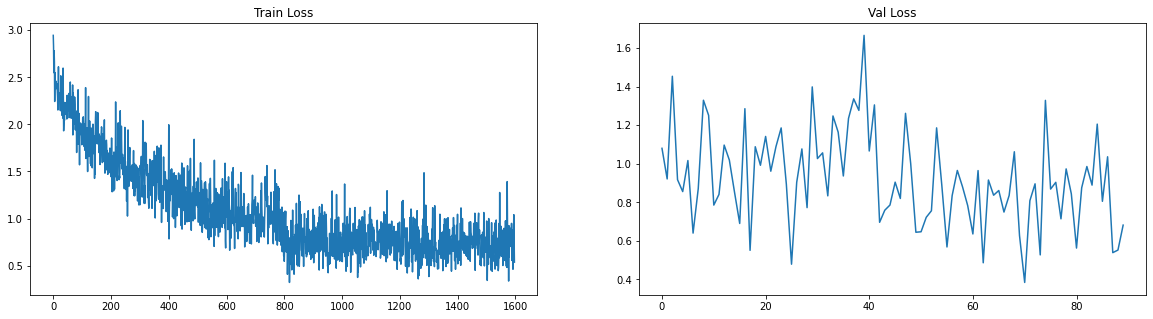

In [115]:
class clf_6(torch.nn.Module):
    def __init__(self, VOCAB_SIZE, EMB_DIM, HID_SIZE, N_TARG):
        super().__init__()
        self.VOCAB_SIZE = VOCAB_SIZE
        self.EMB_DIM = EMB_DIM
        self.HID_SIZE = HID_SIZE
        self.N_TARG = N_TARG
        self.embedding = torch.nn.Embedding(self.VOCAB_SIZE + 1, self.EMB_DIM)
        self.gru = torch.nn.GRU(self.EMB_DIM, self.HID_SIZE, batch_first=True, bidirectional=True)
        self.lstm = torch.nn.LSTM(2 * self.HID_SIZE, self.HID_SIZE, batch_first=True, bidirectional=True)
        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(.3),
            torch.nn.Linear(2 * self.HID_SIZE, self.HID_SIZE),
            torch.nn.Dropout(.3),
            torch.nn.Linear(self.HID_SIZE, self.N_TARG),
            torch.nn.LogSoftmax()
        )
        
    def forward(self, input_ids):
        embedding = self.embedding(input_ids)
        backward_embedding = torch.flip(embedding, (1,))
        
        gru_output, gru_h = self.gru(embedding)
        gru_output_backward, gru_h_backward = self.gru(backward_embedding)
        lstm_output, (lstm_h, _) = self.lstm(gru_output)
        lstm_output_backward, (lstm_h_backward, _) = self.lstm(gru_output_backward)
        conc_h = torch.cat([lstm_h[-1], lstm_h_backward[-1]], axis=1)
        scores = self.classifier(conc_h)
        return scores
    
vocab_size = len(filtered_vocab)

n_epochs = 2

model = clf_6(vocab_size, emb_dim, hidden_size, n_target)
model.to(device)

model, loss_set, val_loss_set = train_model(model = model, 
                                            n_epochs = n_epochs, 
                                            train_dataloader = train_dataloader, 
                                            validation_dataloader = val_dataloader,
                                            lr = 1e-3)

plot_losses(loss_set, val_loss_set)

Используем распараллеливание для более быстрого обучения моделей.

  0%|          | 0/200 [00:00<?, ?it/s]


Epoch 0 ... Train f1: 0.58 ... Mean train loss: 1.2105



  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 0 ... Val f1: 0.55 ... Mean val loss: 1.3363

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/200 [00:00<?, ?it/s]


Epoch 1 ... Train f1: 0.64 ... Mean train loss: 1.0462



  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 1 ... Val f1: 0.57 ... Mean val loss: 1.3476

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/200 [00:00<?, ?it/s]


Epoch 2 ... Train f1: 0.68 ... Mean train loss: 0.9366



  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 2 ... Val f1: 0.61 ... Mean val loss: 1.2416

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/200 [00:00<?, ?it/s]


Epoch 3 ... Train f1: 0.66 ... Mean train loss: 1.0035



  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 3 ... Val f1: 0.62 ... Mean val loss: 1.1905

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/12 [00:00<?, ?it/s]

Final epoch ... test f1: 0.62 ... Mean test loss: 1.2099


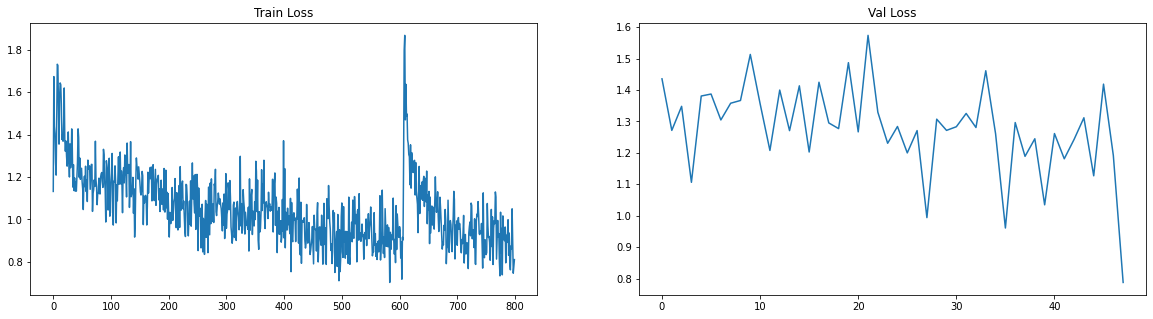

In [29]:
class clf_7(torch.nn.Module):
    def __init__(self, VOCAB_SIZE, EMB_DIM, HID_SIZE, N_TARG):
        super().__init__()
        self.VOCAB_SIZE = VOCAB_SIZE
        self.EMB_DIM = EMB_DIM
        self.HID_SIZE = HID_SIZE
        self.N_TARG = N_TARG
        self.embedding = torch.nn.Embedding(self.VOCAB_SIZE + 1, self.EMB_DIM)
        self.lstm_1 = torch.nn.LSTM(self.EMB_DIM, self.HID_SIZE, batch_first=True)
        self.gru_1 = torch.nn.GRU(self.HID_SIZE, self.HID_SIZE, batch_first=True)
        self.bilstm = torch.nn.LSTM(self.HID_SIZE, self.HID_SIZE, batch_first=True, bidirectional=True)
        self.bigru = torch.nn.GRU(2 * self.HID_SIZE, 2 * self.HID_SIZE, batch_first=True, bidirectional=True)
        self.gru_2 = torch.nn.GRU(4 * self.HID_SIZE, 2 * self.HID_SIZE, batch_first=True)
        self.lstm_2 = torch.nn.LSTM(2 * self.HID_SIZE, self.HID_SIZE, batch_first=True)
        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(.3),
            torch.nn.Linear(self.HID_SIZE, self.N_TARG),
            torch.nn.LogSoftmax()
        )
        
    def forward(self, input_ids):
        embedding = self.embedding(input_ids)
        output, (h, _) = self.lstm_1(embedding)
        output, h = self.gru_1(output)
        output, (h, _) = self.bilstm(output)
        output, h = self.bigru(output)
        output, h = self.gru_2(output)
        output, (h, _) = self.lstm_2(output)
        scores = self.classifier(h[-1])
        return scores
    
vocab_size = len(filtered_vocab)

n_epochs = 4

model = clf_7(vocab_size, emb_dim, hidden_size, n_target)

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = torch.nn.DataParallel(model)
    
model.to(device)

model, loss_set, val_loss_set = train_model(model = model, 
                                            n_epochs = n_epochs, 
                                            train_dataloader = train_dataloader, 
                                            validation_dataloader = val_dataloader,
                                            lr = 1e-3)

plot_losses(loss_set, val_loss_set)

Let's use 4 GPUs!


  0%|          | 0/200 [00:00<?, ?it/s]


Epoch 0 ... Train f1: 0.12 ... Mean train loss: 2.3236



  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 0 ... Val f1: 0.11 ... Mean val loss: 2.2565

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/200 [00:00<?, ?it/s]


Epoch 1 ... Train f1: 0.15 ... Mean train loss: 2.2636



  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 1 ... Val f1: 0.14 ... Mean val loss: 2.2317

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/200 [00:00<?, ?it/s]


Epoch 2 ... Train f1: 0.16 ... Mean train loss: 2.2527



  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 2 ... Val f1: 0.15 ... Mean val loss: 2.2133

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/200 [00:00<?, ?it/s]


Epoch 3 ... Train f1: 0.21 ... Mean train loss: 2.0826



  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 3 ... Val f1: 0.23 ... Mean val loss: 1.8495

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/200 [00:00<?, ?it/s]


Epoch 4 ... Train f1: 0.29 ... Mean train loss: 1.7263



  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 4 ... Val f1: 0.28 ... Mean val loss: 1.6336

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/200 [00:00<?, ?it/s]


Epoch 5 ... Train f1: 0.35 ... Mean train loss: 1.5321



  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 5 ... Val f1: 0.38 ... Mean val loss: 1.5286

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/200 [00:00<?, ?it/s]


Epoch 6 ... Train f1: 0.47 ... Mean train loss: 1.3414



  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 6 ... Val f1: 0.47 ... Mean val loss: 1.4080

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/200 [00:00<?, ?it/s]


Epoch 7 ... Train f1: 0.60 ... Mean train loss: 1.1298



  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 7 ... Val f1: 0.56 ... Mean val loss: 1.3377

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/200 [00:00<?, ?it/s]


Epoch 8 ... Train f1: 0.68 ... Mean train loss: 0.9453



  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 8 ... Val f1: 0.58 ... Mean val loss: 1.3386

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/200 [00:00<?, ?it/s]


Epoch 9 ... Train f1: 0.73 ... Mean train loss: 0.8013



  0%|          | 0/12 [00:00<?, ?it/s]


Epoch 9 ... Val f1: 0.60 ... Mean val loss: 1.3631

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/12 [00:00<?, ?it/s]

Final epoch ... test f1: 0.59 ... Mean test loss: 1.4322


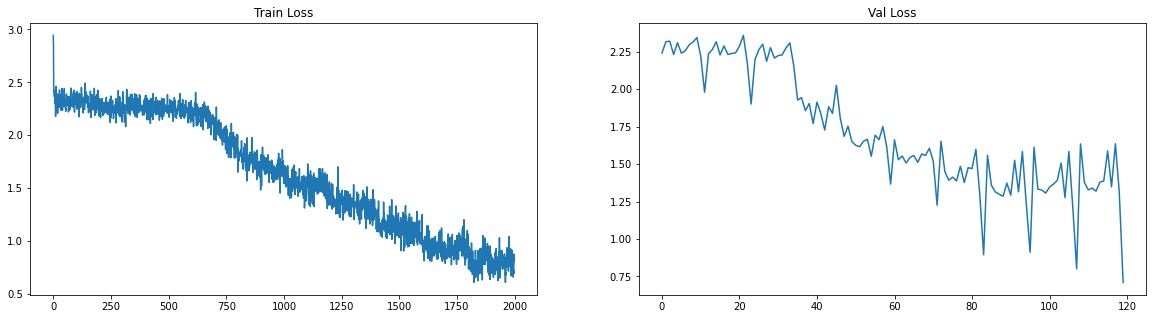

In [26]:
class clf_8(torch.nn.Module):
    def __init__(self, VOCAB_SIZE, EMB_DIM, HID_SIZE, N_TARG):
        super().__init__()
        self.VOCAB_SIZE = VOCAB_SIZE
        self.EMB_DIM = EMB_DIM
        self.HID_SIZE = HID_SIZE
        self.N_TARG = N_TARG
        self.embedding = torch.nn.Embedding(self.VOCAB_SIZE + 1, self.EMB_DIM)
        self.gru = torch.nn.GRU(self.EMB_DIM, self.HID_SIZE, num_layers=50, batch_first=True)
        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(.3),
            torch.nn.Linear(self.HID_SIZE, self.N_TARG),
            torch.nn.LogSoftmax()
        )
        
    def forward(self, input_ids):
        embedding = self.embedding(input_ids)
        output, h = self.gru(embedding)
        scores = self.classifier(h.mean(axis=0))
        return scores

n_epochs = 10

model = clf_8(vocab_size, emb_dim, hidden_size, n_target)

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = torch.nn.DataParallel(model)
    
model.to(device)

model, loss_set, val_loss_set = train_model(model = model, 
                                            n_epochs = n_epochs, 
                                            train_dataloader = train_dataloader, 
                                            validation_dataloader = val_dataloader,
                                            lr = 0.001)

plot_losses(loss_set, val_loss_set)

<b>Вывод:</b> Модель clf_1 показала лучшее качество на тестовой выборке в 0.76, построена на GRU. LSTM - работает не стабильно, обучать сложнее, из раза в раз показывает разные результаты. Усложненные модели прироста в качестве не дают, да и не достигают того качества что дает модель с одним слоем.

## Задание 2 (6 баллов)


На данных википедии (wikiann) обучите 2 модели:  
1) модель в которой будут использованы предобученные эмбединги слов и несколько BILSTM слоев. 
1) модель в которой будут использованы предобученные эмбединги слов и несколько BIGRU слоев. 

Сравните качество по метрикам. Также придумайте несколько сложных примеров и проверьте, какие сущности определяет каждая из моделей.

In [3]:
from datasets import load_dataset

In [4]:
dataset = load_dataset('wikiann', 'ru')

Reusing dataset wikiann (/home/nanosemantics/.cache/huggingface/datasets/wikiann/ru/1.1.0/4bfd4fe4468ab78bb6e096968f61fab7a888f44f9d3371c2f3fea7e74a5a354e)


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
# словарь
vocab = Counter()

for sent in dataset['train']['tokens']:
    vocab.update([x.lower() for x in sent])

In [6]:
# индексируем слова
word2id = {'PAD':0, 'UNK':1}

for word in vocab:
    word2id[word] = len(word2id)

In [7]:
len(word2id)

36017

In [8]:
id2word = {i:word for word, i in word2id.items()}

In [9]:
X = []

for sent in dataset['train']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [10]:
X_test = []

for sent in dataset['test']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X_test.append(ids)

In [11]:
X_val = []

for sent in dataset['validation']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X_val.append(ids)

In [12]:
MAX_LEN = max(len(x) for x in X)

X = pad_sequences(X, maxlen=MAX_LEN, padding='post')
X_test = pad_sequences(X_test, maxlen=MAX_LEN, padding='post')
X_val = pad_sequences(X_val, maxlen=MAX_LEN, padding='post')

In [13]:
id2labels = {0:'O', 1:'B-PER', 2:'I-PER', 3:'B-ORG', 4:'I-ORG', 5: 'B-LOC', 6:'I-LOC', 7:'PAD'}
label2id = {v:k for k,v in id2labels.items()} 

In [14]:
y = pad_sequences(dataset['train']['ner_tags'], value=7, maxlen=MAX_LEN, padding='post')
y_test = pad_sequences(dataset['test']['ner_tags'], value=7, maxlen=MAX_LEN, padding='post')
y_val = pad_sequences(dataset['validation']['ner_tags'], value=7, maxlen=MAX_LEN, padding='post')

In [15]:
y.shape, X.shape

((20000, 54), (20000, 54))

In [16]:
X = torch.tensor(X)
X_test = torch.tensor(X_test)
X_val = torch.tensor(X_val)

y = torch.tensor(y)
y_test = torch.tensor(y_test)
y_val = torch.tensor(y_val)

In [17]:
train_dataset = torch.utils.data.TensorDataset(X, y)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)

In [18]:
batch_size = 200

train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size, 
                                               sampler=torch.utils.data.RandomSampler(train_dataset))

val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                                             batch_size, 
                                             sampler=torch.utils.data.SequentialSampler(val_dataset))

test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                              batch_size, 
                                              sampler=torch.utils.data.SequentialSampler(test_dataset))

In [19]:
x, y = list(train_dataloader)[0]

In [20]:
x.shape

torch.Size([200, 54])

In [21]:
vocab_size = len(word2id)
n_target = len(label2id)
emb_dim = 300
hidden_size = 256

In [22]:
def train_model(model, n_epochs, train_dataloader, validation_dataloader, lr):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, threshold=0.001)
    loss = torch.nn.CrossEntropyLoss()
    loss_set = []
    val_loss_set = []
    
    for epoch in range(n_epochs):
        epoch_loss_set = []
        model.train()

        for j, batch in enumerate(tqdm(train_dataloader)):
              
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_labels = batch
              
            optimizer.zero_grad()
            pred_probs = model.forward(b_input_ids)
            pred_probs = pred_probs.permute(0, 2, 1)
            my_loss = loss(pred_probs, b_labels.long())
            epoch_loss_set.append(my_loss.item())
            my_loss.backward()
                  
            pred_probs = pred_probs.detach().to('cpu').numpy()
            pred_labels = pred_probs.argmax(axis=1)
            b_labels = b_labels.to('cpu').numpy()
            
            optimizer.step()
              
            if j == 0:
                all_train_labels = b_labels
                all_train_preds = pred_labels
            else:
                all_train_labels = np.vstack([all_train_labels, b_labels])
                all_train_preds = np.vstack([all_train_preds, pred_labels])
                
        #scheduler.step(np.mean(epoch_loss_set))  
        
        loss_set.extend(epoch_loss_set)
          
        train_f1 = f1_score(all_train_labels.reshape(-1), all_train_preds.reshape(-1), average='macro')
        #print(classification_report(all_train_labels.reshape(-1), all_train_preds.reshape(-1), target_names=label2id.keys()))  
        print()
        print('Epoch {} ... Train f1: {:.2f} ... Mean train loss: {:.4f}'.format(epoch, train_f1, np.mean(epoch_loss_set)))
        print()

        epoch_val_loss_set = []

        model.eval()

        for j, batch in enumerate(tqdm(validation_dataloader)):
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_labels = batch
              
  #             val_labels = np.zeros([b_labels.shape[0], n_target])
  #             val_preds = np.zeros([b_labels.shape[0], n_target])
              
            with torch.no_grad():
                pred_probs = model.forward(b_input_ids)
                pred_probs = pred_probs.permute(0, 2, 1)
                val_loss = loss(pred_probs, b_labels.long())
                epoch_val_loss_set.append(val_loss.item())

                b_labels = b_labels.to('cpu').numpy()
                pred_probs = pred_probs.detach().to('cpu').numpy()
                pred_labels = pred_probs.argmax(axis=1)
              
            if j == 0:
                all_val_labels = b_labels
                all_val_preds = pred_labels
            else:
                all_val_labels = np.vstack([all_val_labels, b_labels])
                all_val_preds = np.vstack([all_val_preds, pred_labels])
          
        #scheduler.step(np.mean(epoch_val_loss_set))
          
        val_loss_set.extend(epoch_val_loss_set)

        val_f1 = f1_score(all_val_labels.reshape(-1), all_val_preds.reshape(-1), average='macro')
        #print(classification_report(all_val_labels.reshape(-1), all_val_preds.reshape(-1), target_names=label2id.keys()))  
        print()
        print('Epoch {} ... Val f1: {:.2f} ... Mean val loss: {:.4f}'.format(epoch, val_f1, np.mean(epoch_val_loss_set)))
        print()
        print('-------------------------------------------------------------------------------------------------------------------------')
        print()
        
    test_labels, test_pred_labels, test_loss_set = predict_test_labels(model, test_dataloader)
    test_f1 = f1_score(test_labels.reshape(-1), test_pred_labels.reshape(-1), average='macro')
    print(classification_report(all_val_labels.reshape(-1), all_val_preds.reshape(-1), target_names=label2id.keys()))
    print()
    print('Final epoch ... test f1: {:.2f} ... Mean test loss: {:.4f}'.format(test_f1, np.mean(test_loss_set)))
    
    return model, loss_set, val_loss_set

def predict_test_labels(model, test_dataloader):
    loss = torch.nn.CrossEntropyLoss()
    test_preds = []
    test_labels = []
    test_loss_set = []
    for batch in tqdm(test_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_labels = batch
        with torch.no_grad():
            pred_probs = model.forward(b_input_ids)
            pred_probs = pred_probs.permute(0, 2, 1)
            pred_labels = pred_probs.detach().to('cpu').numpy()
            pred_labels = pred_labels.argmax(axis=1)
            test_loss = loss(pred_probs, b_labels.long())
            test_loss_set.append(test_loss.item())
            test_preds.extend(pred_labels)
            test_labels.extend(b_labels.to('cpu').numpy())
    return np.array(test_labels), np.array(test_preds), test_loss_set

def plot_losses(train_loss, val_loss):
    plt.figure(figsize=(20,5))

    fig = plt.figure(1)
    axis = fig.add_subplot(1,2,1)
    axis.plot(train_loss)
    plt.title('Train Loss')

    fig = plt.figure(1)
    axis = fig.add_subplot(1,2,2)
    axis.plot(val_loss)
    plt.title('Val Loss')

    plt.show()

In [23]:
class clfNER(torch.nn.Module):
    def __init__(self, VOCAB_SIZE, EMB_DIM, HID_SIZE, N_TARG, rnn_type):
        super().__init__()
        self.VOCAB_SIZE = VOCAB_SIZE
        self.EMB_DIM = EMB_DIM
        self.HID_SIZE = HID_SIZE
        self.N_TARG = N_TARG
        self.rnn_type = rnn_type
        self.embedding = torch.nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)
        
        if self.rnn_type == 'gru':
            self.rnn = torch.nn.GRU(self.EMB_DIM, self.HID_SIZE, num_layers=1, batch_first=True, bidirectional=True)
        elif self.rnn_type == 'lstm':
            self.rnn = torch.nn.LSTM(self.EMB_DIM, self.HID_SIZE, num_layers=1, batch_first=True, bidirectional=True)
            
        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(.1),
            torch.nn.Linear(2 * self.HID_SIZE, self.N_TARG),
            torch.nn.Softmax(dim=2)
        )
        
    def init_embedding(self, embedding):
        embedding.to(device)
        self.embedding.weight = torch.nn.Parameter(embedding, requires_grad=True)
        
    def forward(self, input_ids):
        embedding = self.embedding(input_ids)
        output, h = self.rnn(embedding)
        scores = self.classifier(output)
        return scores

Модель без использования предобученных эмбеддингов:

  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 0 ... Train f1: 0.33 ... Mean train loss: 1.3391



  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 0 ... Val f1: 0.45 ... Mean val loss: 1.3143

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 1 ... Train f1: 0.49 ... Mean train loss: 1.3111



  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 1 ... Val f1: 0.51 ... Mean val loss: 1.3091

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 2 ... Train f1: 0.54 ... Mean train loss: 1.3071



  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 2 ... Val f1: 0.56 ... Mean val loss: 1.3054

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 3 ... Train f1: 0.58 ... Mean train loss: 1.3035



  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 3 ... Val f1: 0.58 ... Mean val loss: 1.3035

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 4 ... Train f1: 0.63 ... Mean train loss: 1.3006



  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 4 ... Val f1: 0.62 ... Mean val loss: 1.3015

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 5 ... Train f1: 0.67 ... Mean train loss: 1.2973



  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 5 ... Val f1: 0.67 ... Mean val loss: 1.2986

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 6 ... Train f1: 0.72 ... Mean train loss: 1.2935



  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 6 ... Val f1: 0.69 ... Mean val loss: 1.2965

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 7 ... Train f1: 0.75 ... Mean train loss: 1.2907



  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 7 ... Val f1: 0.71 ... Mean val loss: 1.2952

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 8 ... Train f1: 0.84 ... Mean train loss: 1.2873



  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 8 ... Val f1: 0.79 ... Mean val loss: 1.2926

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 9 ... Train f1: 0.89 ... Mean train loss: 1.2843



  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 9 ... Val f1: 0.81 ... Mean val loss: 1.2917

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/50 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           O       0.89      0.98      0.93     39966
       B-PER       0.88      0.77      0.82      3590
       I-PER       0.90      0.85      0.88      7570
       B-ORG       0.72      0.60      0.65      3892
       I-ORG       0.82      0.75      0.78      7299
       B-LOC       0.81      0.62      0.70      4850
       I-LOC       0.80      0.61      0.69      3105
         PAD       1.00      1.00      1.00    469728

    accuracy                           0.98    540000
   macro avg       0.85      0.77      0.81    540000
weighted avg       0.98      0.98      0.98    540000


Final epoch ... test f1: 0.81 ... Mean test loss: 1.2918


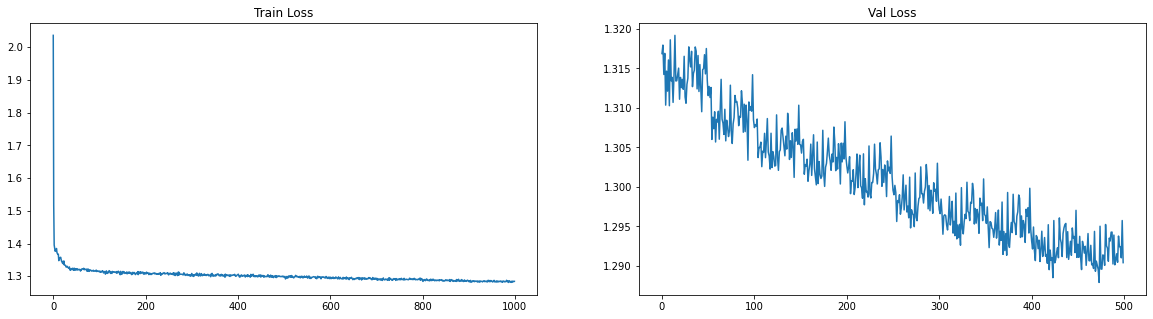

In [26]:
model = clfNER(vocab_size, emb_dim, hidden_size, n_target, 'gru')

model.to(device)

n_epochs = 10
model, loss_set, val_loss_set = train_model(model = model, 
                                            n_epochs = n_epochs, 
                                            train_dataloader = train_dataloader, 
                                            validation_dataloader = val_dataloader,
                                            lr = 1e-3)
plot_losses(loss_set, val_loss_set)

Получили 0.81 на тесте - в принципе не плохо. Возьмем какие-нибудь эмбеддинги и попробуем обучить модель на их основе:

In [27]:
import fasttext.util
fasttext.util.download_model('ru', if_exists='ignore')

'cc.ru.300.bin'

In [28]:
ft = fasttext.load_model('cc.ru.300.bin')

In [29]:
weights = np.zeros((len(word2id), emb_dim))

for word, i in word2id.items():
    if word == 'PAD':
        continue
    elif word == 'UNK':
        weights[i] = ft.get_word_vector('опрагпллирао')

    try:
        weights[i] = ft.get_word_vector(word)
    
    except KeyError:
        continue
        weights[i] = ft.get_word_vector('опрагпллирао')
        
weights = torch.tensor(weights, dtype=torch.float)

Функция инициализации эмбеддингов уже есть в составе нашего класса, вызовем ее, и обучим модель:

  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 0 ... Train f1: 0.12 ... Mean train loss: 1.4650



  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 0 ... Val f1: 0.12 ... Mean val loss: 1.4041

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 1 ... Train f1: 0.12 ... Mean train loss: 1.4050



  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 1 ... Val f1: 0.12 ... Mean val loss: 1.4041

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 2 ... Train f1: 0.12 ... Mean train loss: 1.4050



  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 2 ... Val f1: 0.12 ... Mean val loss: 1.4041

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 3 ... Train f1: 0.14 ... Mean train loss: 1.3970



  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 3 ... Val f1: 0.20 ... Mean val loss: 1.3497

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 4 ... Train f1: 0.22 ... Mean train loss: 1.3342



  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 4 ... Val f1: 0.22 ... Mean val loss: 1.3298

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 5 ... Train f1: 0.27 ... Mean train loss: 1.3268



  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 5 ... Val f1: 0.31 ... Mean val loss: 1.3188

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 6 ... Train f1: 0.46 ... Mean train loss: 1.3095



  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 6 ... Val f1: 0.51 ... Mean val loss: 1.3070

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 7 ... Train f1: 0.53 ... Mean train loss: 1.2995



  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 7 ... Val f1: 0.49 ... Mean val loss: 1.3074

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 8 ... Train f1: 0.63 ... Mean train loss: 1.2943



  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 8 ... Val f1: 0.61 ... Mean val loss: 1.3032

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 9 ... Train f1: 0.79 ... Mean train loss: 1.2862



  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 9 ... Val f1: 0.66 ... Mean val loss: 1.3013

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 10 ... Train f1: 0.83 ... Mean train loss: 1.2830



  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 10 ... Val f1: 0.63 ... Mean val loss: 1.3031

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 11 ... Train f1: 0.83 ... Mean train loss: 1.2820



  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 11 ... Val f1: 0.63 ... Mean val loss: 1.3029

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 12 ... Train f1: 0.84 ... Mean train loss: 1.2815



  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 12 ... Val f1: 0.63 ... Mean val loss: 1.3027

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 13 ... Train f1: 0.84 ... Mean train loss: 1.2811



  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 13 ... Val f1: 0.63 ... Mean val loss: 1.3024

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 14 ... Train f1: 0.84 ... Mean train loss: 1.2809



  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 14 ... Val f1: 0.62 ... Mean val loss: 1.3025

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 15 ... Train f1: 0.84 ... Mean train loss: 1.2808



  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 15 ... Val f1: 0.61 ... Mean val loss: 1.3033

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 16 ... Train f1: 0.84 ... Mean train loss: 1.2807



  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 16 ... Val f1: 0.62 ... Mean val loss: 1.3029

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 17 ... Train f1: 0.84 ... Mean train loss: 1.2806



  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 17 ... Val f1: 0.63 ... Mean val loss: 1.3025

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 18 ... Train f1: 0.84 ... Mean train loss: 1.2806



  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 18 ... Val f1: 0.63 ... Mean val loss: 1.3026

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 19 ... Train f1: 0.84 ... Mean train loss: 1.2805



  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 19 ... Val f1: 0.61 ... Mean val loss: 1.3038

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 20 ... Train f1: 0.84 ... Mean train loss: 1.2805



  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 20 ... Val f1: 0.62 ... Mean val loss: 1.3030

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 21 ... Train f1: 0.84 ... Mean train loss: 1.2804



  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 21 ... Val f1: 0.62 ... Mean val loss: 1.3030

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 22 ... Train f1: 0.84 ... Mean train loss: 1.2804



  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 22 ... Val f1: 0.62 ... Mean val loss: 1.3035

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 23 ... Train f1: 0.84 ... Mean train loss: 1.2804



  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 23 ... Val f1: 0.62 ... Mean val loss: 1.3027

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 24 ... Train f1: 0.84 ... Mean train loss: 1.2803



  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 24 ... Val f1: 0.62 ... Mean val loss: 1.3036

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/50 [00:00<?, ?it/s]

/home/nanosemantics/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           O       0.91      0.92      0.91     39966
       B-PER       0.76      0.61      0.68      3590
       I-PER       0.86      0.39      0.53      7570
       B-ORG       0.37      0.86      0.52      3892
       I-ORG       0.57      0.85      0.68      7299
       B-LOC       0.73      0.54      0.62      4850
       I-LOC       0.00      0.00      0.00      3105
         PAD       1.00      1.00      1.00    469728

    accuracy                           0.97    540000
   macro avg       0.65      0.65      0.62    540000
weighted avg       0.97      0.97      0.97    540000


Final epoch ... test f1: 0.62 ... Mean test loss: 1.3033


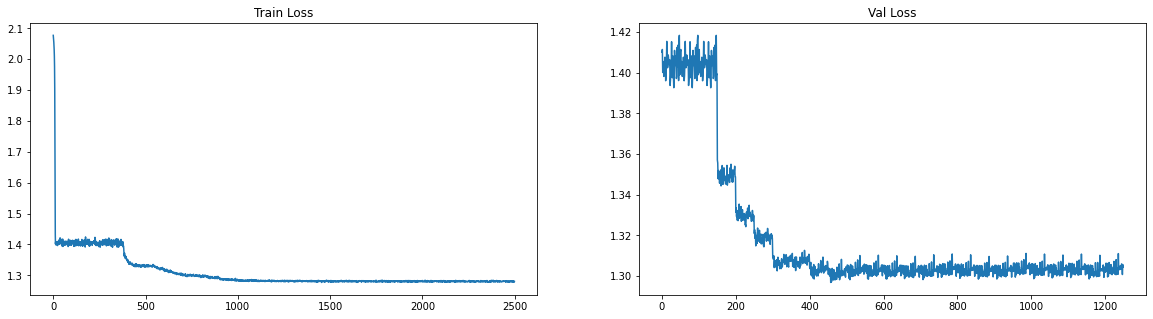

In [31]:
model = clfNER(vocab_size, emb_dim, hidden_size, n_target, 'lstm')
model.init_embedding(weights)

model.to(device)

n_epochs = 25
model, loss_set, val_loss_set = train_model(model = model, 
                                            n_epochs = n_epochs, 
                                            train_dataloader = train_dataloader, 
                                            validation_dataloader = val_dataloader,
                                            lr = 9e-4)

plot_losses(loss_set, val_loss_set)

Результат 0.62 хуже, чем без эмбеддингов. Возможно эмбеддинги плохие, либо LSTM не дает обучиться, попробуем с GRU:

In [ ]:
0.001 0.0009

  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 0 ... Train f1: 0.44 ... Mean train loss: 1.3323



  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 0 ... Val f1: 0.53 ... Mean val loss: 1.3068

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 1 ... Train f1: 0.60 ... Mean train loss: 1.3010



  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 1 ... Val f1: 0.59 ... Mean val loss: 1.3019

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 2 ... Train f1: 0.72 ... Mean train loss: 1.2931



  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 2 ... Val f1: 0.69 ... Mean val loss: 1.2987

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 3 ... Train f1: 0.85 ... Mean train loss: 1.2856



  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 3 ... Val f1: 0.77 ... Mean val loss: 1.2949

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 4 ... Train f1: 0.91 ... Mean train loss: 1.2815



  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 4 ... Val f1: 0.78 ... Mean val loss: 1.2942

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 5 ... Train f1: 0.93 ... Mean train loss: 1.2799



  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 5 ... Val f1: 0.79 ... Mean val loss: 1.2934

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 6 ... Train f1: 0.94 ... Mean train loss: 1.2790



  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 6 ... Val f1: 0.79 ... Mean val loss: 1.2934

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/50 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           O       0.89      0.97      0.92     39966
       B-PER       0.94      0.71      0.81      3590
       I-PER       0.93      0.72      0.81      7570
       B-ORG       0.67      0.64      0.66      3892
       I-ORG       0.78      0.71      0.74      7299
       B-LOC       0.69      0.69      0.69      4850
       I-LOC       0.70      0.64      0.67      3105
         PAD       1.00      1.00      1.00    469728

    accuracy                           0.98    540000
   macro avg       0.82      0.76      0.79    540000
weighted avg       0.98      0.98      0.98    540000


Final epoch ... test f1: 0.79 ... Mean test loss: 1.2932


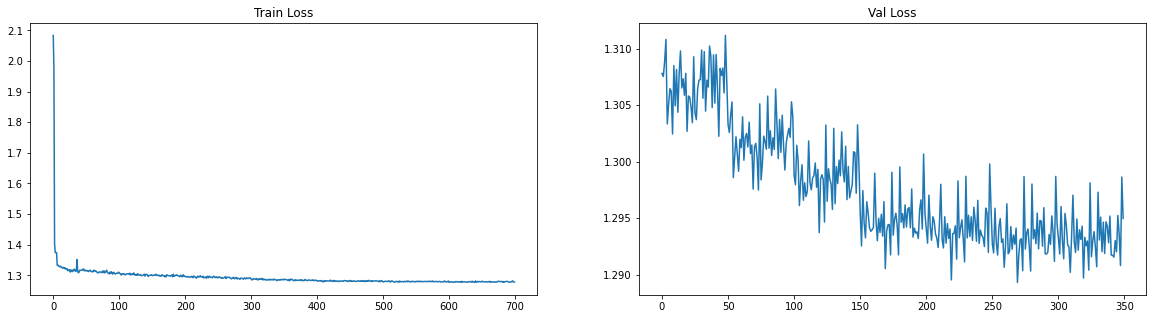

In [34]:
model = clfNER(vocab_size, emb_dim, hidden_size, n_target, 'gru')
model.init_embedding(weights)

model.to(device)

n_epochs = 7
model, loss_set, val_loss_set = train_model(model = model, 
                                            n_epochs = n_epochs, 
                                            train_dataloader = train_dataloader, 
                                            validation_dataloader = val_dataloader,
                                            lr = 8e-3)

plot_losses(loss_set, val_loss_set)

Снизим learning rate и обучим модель еще несколько эпох:

  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 0 ... Train f1: 0.97 ... Mean train loss: 1.2767



  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 0 ... Val f1: 0.80 ... Mean val loss: 1.2921

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 1 ... Train f1: 0.97 ... Mean train loss: 1.2767



  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 1 ... Val f1: 0.80 ... Mean val loss: 1.2921

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 2 ... Train f1: 0.97 ... Mean train loss: 1.2766



  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 2 ... Val f1: 0.80 ... Mean val loss: 1.2923

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 3 ... Train f1: 0.97 ... Mean train loss: 1.2766



  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 3 ... Val f1: 0.80 ... Mean val loss: 1.2924

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 4 ... Train f1: 0.97 ... Mean train loss: 1.2766



  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 4 ... Val f1: 0.80 ... Mean val loss: 1.2924

-------------------------------------------------------------------------------------------------------------------------



  0%|          | 0/50 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           O       0.91      0.95      0.93     39966
       B-PER       0.93      0.71      0.81      3590
       I-PER       0.94      0.77      0.85      7570
       B-ORG       0.50      0.73      0.59      3892
       I-ORG       0.80      0.76      0.78      7299
       B-LOC       0.80      0.70      0.74      4850
       I-LOC       0.75      0.72      0.74      3105
         PAD       1.00      1.00      1.00    469728

    accuracy                           0.98    540000
   macro avg       0.83      0.79      0.80    540000
weighted avg       0.98      0.98      0.98    540000


Final epoch ... test f1: 0.81 ... Mean test loss: 1.2922


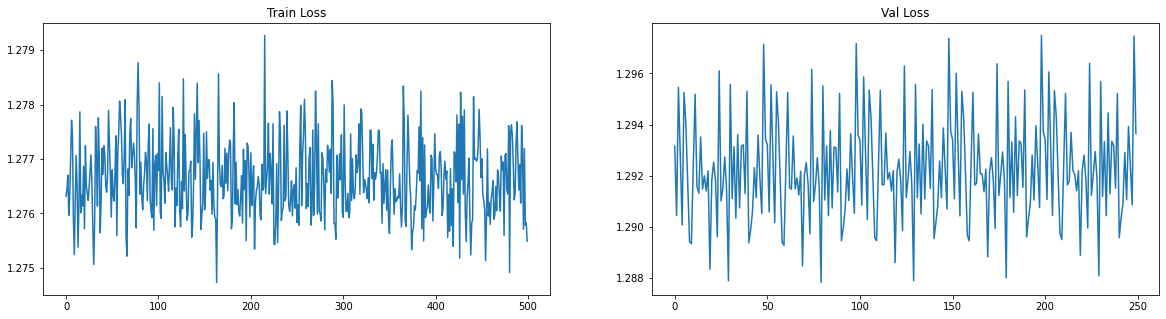

In [37]:
n_epochs = 5
model, loss_set, val_loss_set = train_model(model = model, 
                                            n_epochs = n_epochs, 
                                            train_dataloader = train_dataloader, 
                                            validation_dataloader = val_dataloader,
                                            lr = 1e-4)

plot_losses(loss_set, val_loss_set)

<b>Вывод:</b> Результат у модели на GRU лучше, чем у модели на LSTM, как и в предыдущем задании. Предобученные эмбеддинги не дали значимого прироста по качеству, без их использования качество такое же, а обучается модель быстрее. Возможно проблема в выборе эмбеддингов.